In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd "/content/drive/MyDrive/Colab Notebooks/3-2/"

/content/drive/MyDrive/Colab Notebooks/3-2


In [ ]:
#바이오 companyId와 마켓 데이터 불러오기
import pandas as pd
df = pd.read_parquet('./inner_bio_companyId.parquet')
indexes = list(df['companyId'])

import pyarrow.parquet as pq
import pandas as pd
filters = [('companyId', 'in', indexes)]
df_market = pd.read_parquet('./market', filters=filters, columns=['companyId', 'companyName', 'pricingDate', 'priceClose', 'adjustmentFactor'])
df_market['companyId'] = list(map(int, df_market['companyId']))

In [ ]:
df_market[df_market['companyId'] == 39414143]

,companyId,companyName,pricingDate,priceClose,adjustmentFactor
780636,39414143,Pharnext SA,2023-10-10,0.139500,1.0000000000
780637,39414143,Pharnext SA,2023-10-09,0.179900,1.0000000000
780638,39414143,Pharnext SA,2023-10-06,0.137800,1.0000000000
780639,39414143,Pharnext SA,2023-10-05,0.182200,1.0000000000
780640,39414143,Pharnext SA,2023-10-04,0.220000,1.0000000000
...,...,...,...,...,...
782367,39414143,Pharnext SA,2017-01-06,483000000.000000,1.0000000000
782368,39414143,Pharnext SA,2017-01-05,485500000.000000,1.0000000000
782369,39414143,Pharnext SA,2017-01-04,492000000.000000,1.0000000000
782370,39414143,Pharnext SA,2017-01-03,474500000.000000,1.0000000000


In [ ]:
#바이오 예상치 데이터 불러오기
import pyarrow.parquet as pq
import pandas as pd
filters = [('companyId', 'in', indexes)]
df_estimates = pd.read_parquet('./estimates', filters=filters, columns=['companyId', 'fiscalYear', 'dataItemName', 'dataItemValue', 'periodTypeName', 'ISOCode', 'estimateScaleName'])
df_estimates

,companyId,fiscalYear,dataItemName,dataItemValue,periodTypeName,ISOCode,estimateScaleName
0,24153,0,Consensus Recommendation,1.600000000,Non-Periodic,None,Absolute
1,24153,2023,EBITDA - # of Estimates,4.000000000,Annual,None,Absolute
2,24153,2022,EBITDA - # of Estimates,3.000000000,Annual,None,Absolute
3,24153,2021,EBITDA - # of Estimates,1.000000000,Annual,None,Absolute
4,24153,2024,EBITDA - # of Estimates,4.000000000,Annual,None,Absolute
...,...,...,...,...,...,...,...
92979,1832961004,0,Target Price - # of Estimates,3.000000000,Non-Periodic,None,Absolute
92980,1832961004,0,Target Price Consensus High,35.229000000,Non-Periodic,CNY,Absolute
92981,1832961004,0,Target Price Consensus Low,30.254000000,Non-Periodic,CNY,Absolute
92982,1832961004,0,Target Price Consensus Mean,32.658000000,Non-Periodic,CNY,Absolute


In [ ]:
df_estimates['companyId'] = list(map(int, df_estimates['companyId']))
df_estimates['dataItemValue'] = list(map(float, df_estimates['dataItemValue']))
df_estimates['fiscalYear'] = list(map(int, df_estimates['fiscalYear']))

pd.options.mode.chained_assignment = None
df_est = df_estimates.copy()

for i in range(len(df_est)):
  if df_est['estimateScaleName'][i] == 'Millions':
    df_est['dataItemValue'][i] = df_est['dataItemValue'][i] * 1_000_000
  elif df_est['estimateScaleName'][i] == 'Billions':
    df_est['dataItemValue'][i] = df_est['dataItemValue'][i] * 1_000_000_000
df_est.drop(['estimateScaleName'], axis=1, inplace=True)

#39414143 예상치 데이터가 -e^11이 나옴에 Outlier라고 판단하여 제거
df_est = df_est[df_est['companyId'] != 39414143]
df_est

#Estimates 데이터 항목 리스트
estimates_unique = df_est.groupby(['dataItemName', 'periodTypeName']).size().reset_index(name='freq')
estimates_unique.drop('freq', axis=1, inplace=True)

#얘네만 다룰거임
annual = estimates_unique[estimates_unique['periodTypeName'] == 'Annual']
annual_item = list(annual['dataItemName'])
annual_item

['EBITDA - # of Estimates',
 'EBITDA - Standard Deviation',
 'EBITDA Actual',
 'EBITDA Consensus High',
 'EBITDA Consensus Low',
 'EBITDA Consensus Mean',
 'EBITDA Consensus Median',
 'EPS Normalized - # of Estimates',
 'EPS Normalized - Standard Deviation',
 'EPS Normalized Actual',
 'EPS Normalized Consensus High',
 'EPS Normalized Consensus Low',
 'EPS Normalized Consensus Mean',
 'EPS Normalized Consensus Median',
 'Net Income Normalized - # of Estimates',
 'Net Income Normalized - Standard Deviation',
 'Net Income Normalized Actual',
 'Net Income Normalized Consensus High',
 'Net Income Normalized Consensus Low',
 'Net Income Normalized Consensus Mean',
 'Net Income Normalized Consensus Median',
 'Revenue - # of Estimates',
 'Revenue - Standard Deviation',
 'Revenue Actual',
 'Revenue Consensus High',
 'Revenue Consensus Low',
 'Revenue Consensus Mean',
 'Revenue Consensus Median']

In [ ]:
#환율 데이터 불러오기 + 22년 ~ 23년까지 Currency별로 데이터프레임 정리
import pyarrow.parquet as pq
import pandas as pd
df_exchange = pd.read_parquet('./exchange')

df_ex = df_exchange.copy()
df_ex.sort_values('priceDate', ascending=True, inplace=True)
df_ex.set_index('priceDate', drop=True, inplace=True)

code = list(df_ex['ISOCode'].unique())
fx = pd.DataFrame()

for c in code:
  ex = df_ex[(df_ex['ISOCode'] == c)].copy()
  ex.rename(columns={'priceClose' : c}, inplace=True)
  ex.drop(['ISOCode'], axis=1, inplace=True)
  d = ex.loc['2022-09-22':'2023-09-22'].copy()
  d = d[~d.index.duplicated(keep='first')]
  d = d.apply(pd.to_numeric, errors='coerce')
  fx = pd.concat([fx, d], axis=1)

In [ ]:
#바이오 재무 데이터 불러오기

import pyarrow.parquet as pq
import pandas as pd
filters = [('companyId', 'in', indexes)]
df_finance = pd.read_parquet('./financials', filters=filters, columns=['companyId', 'periodTypeName', 'fiscalQuarter', 'fiscalYear', 'dataItemName', 'dataItemValue', 'ISOCode', 'unitTypeValue'])

#데이터 처리를 위해 필요한 칼럼들을 Int 형태로 변환
df_finance['companyId'] = list(map(int, df_finance['companyId']))
df_finance['dataItemValue'] = list(map(float, df_finance['dataItemValue']))
df_finance['fiscalYear'] = list(map(int, df_finance['fiscalYear']))
df_finance['unitTypeValue'] = list(map(int, df_finance['unitTypeValue']))

#주어진 UnitTypeValue를 Value에 곱하여 단위를 맞춰줌

df_finance['dataItemValue'] = df_finance['dataItemValue'] * df_finance['unitTypeValue']
df_finance.drop(['unitTypeValue'], axis=1, inplace=True)

##39414143 기업의 데이터가 Outlier라고 판단하여 제거
df_finance = df_finance[df_finance['companyId'] != 39414143]

#재무 데이터 중 고유 아이템을 그룹으로 묶어서 분류
financials_unique = df_finance.groupby(['dataItemName', 'periodTypeName']).size().reset_index(name='freq')
financials_unique.drop('freq', axis=1, inplace=True)
financials_unique

,dataItemName,periodTypeName
0,(Gain) Loss From Sale Of Asset,Annual
1,(Gain) Loss From Sale Of Asset,Quarterly
2,(Gain) Loss on Sale of Investments - (CF),Annual
3,(Gain) Loss on Sale of Investments - (CF),Quarterly
4,(Income) Loss On Equity Investments - (CF),Annual
...,...,...
346,Treasury Stock & Other,Quarterly
347,"Unearned Revenue Current, Total",Annual
348,"Unearned Revenue Current, Total",Quarterly
349,Unearned Revenue Non Current,Annual


In [ ]:
#한 고유 데이터가 분기별, 연간별로 두 개로 나누어져서 존재함
#그 중에 분기별 데이터만 사용함
quarter = financials_unique[financials_unique['periodTypeName'] == 'Quarterly']
quarter_item = list(quarter['dataItemName'])
quarter_item

['(Gain) Loss From Sale Of Asset',
 '(Gain) Loss on Sale of Investments - (CF)',
 '(Income) Loss On Equity Investments - (CF)',
 'Accounts Payable, Total',
 'Accounts Receivable Long-Term',
 'Accounts Receivable, Total',
 'Accrued Expenses, Total',
 'Accumulated Depreciation',
 'Additional Paid In Capital',
 'Amortization of Deferred Charges, Total - (CF)',
 'Amortization of Goodwill and Intangible Assets - (CF) - (Template Specific)',
 'Amortization of Goodwill and Intangible Assets - (IS)',
 'Asset Writedown',
 'Asset Writedown & Restructuring Costs',
 'Capital Expenditure',
 'Cash Acquisitions',
 'Cash And Equivalents',
 'Cash from Financing',
 'Cash from Investing',
 'Cash from Operations',
 'Change In Accounts Payable',
 'Change In Accounts Receivable',
 'Change In Deferred Taxes',
 'Change In Income Taxes',
 'Change In Inventories',
 'Change in Net Operating Assets',
 'Change in Other Net Operating Assets',
 'Change in Trading Asset Securities',
 'Change in Unearned Revenues',
 '

In [ ]:
#재무 데이터가 존재하는 기업이 많이 없는 경우가 있어 데이터 당 기업이 500개 이상인 기업에 대해서만 분석을 진행
financial_item = []
for item in quarter_item:
  example_feature = df_finance[(df_finance['dataItemName'] == item) & (df_finance['periodTypeName'] == 'Quarterly')]
  id = len(example_feature['companyId'].unique())
  if id > 500:
    financial_item.append(item)

print(len(financial_item))

109


In [ ]:
from tqdm import tqdm

In [ ]:
#마켓 데이터로부터 기업의 주가를 시계열로 데이터로 정리
df_price = df_market.copy()
df_price['price'] = df_price['priceClose'] * df_price['adjustmentFactor']
df_price['price'] = df_price['price'].apply(lambda x: round(x, 4))
df_price.drop(['priceClose', 'adjustmentFactor'], axis=1, inplace=True)

df_price['companyId'] = list(map(int, df_price['companyId']))
#unique_id = list(df_price['companyId'].unique())
unique_id = list(df_price['companyName'].unique())
market = pd.DataFrame()

#팩터 모델링을 위한 Training의 기간은 21년 9월 22일부터 22년 9월 22일까지
for id in tqdm(unique_id):
  ex = df_price[(df_price['companyName'] == id)].copy()
  ex.rename(columns={'price' : id}, inplace=True)
  ex.drop(['companyName'], axis=1, inplace=True)
  ex.sort_values(by='pricingDate', inplace=True)
  ex.set_index('pricingDate', inplace=True, drop=True)
  d = ex.loc['2022-09-22':'2023-09-22'].copy()
  d = d[~d.index.duplicated(keep='first')]
  d = d.apply(pd.to_numeric, errors='coerce')
  market = pd.concat([market, d], axis=1)

market2 = market.copy()

"""
mark_date = market2.isnull().sum(axis=1).index
mark_col = market2.isnull().sum(axis=0).index


#한 날짜에 850개 초과의 기업이 주가가 없다면 해당 날짜 제거 (공휴일이라 판단)
for i in mark_date:
  if market2.isnull().sum(axis=1)[i] > 850:
    market2.drop(i, inplace=True)

#한 기업이 40일 이상의 주가가 없으면 제거 (결측치가 너무 많으면 평균이나 선형보간법으로 결측치를 채우는게 무리가 있다고 판단)
for i in mark_col:
  if market2.isnull().sum(axis=0)[i] > 40:
    market2.drop(i, axis=1, inplace=True)

#선형 보간법으로 우선 채우고 연속된 결측치의 경우에는 전 값으로 결측치를 처리
market2.interpolate(method='linear', inplace=True)
market2.fillna(method='bfill', inplace=True)
market2.drop('Pharnext SA', axis=1, inplace=True)
"""

100%|██████████| 1699/1699 [05:56<00:00,  4.77it/s]


"\nmark_date = market2.isnull().sum(axis=1).index\nmark_col = market2.isnull().sum(axis=0).index\n\n\n#한 날짜에 850개 초과의 기업이 주가가 없다면 해당 날짜 제거 (공휴일이라 판단)\nfor i in mark_date:\n  if market2.isnull().sum(axis=1)[i] > 850:\n    market2.drop(i, inplace=True)\n\n#한 기업이 40일 이상의 주가가 없으면 제거 (결측치가 너무 많으면 평균이나 선형보간법으로 결측치를 채우는게 무리가 있다고 판단)\nfor i in mark_col:\n  if market2.isnull().sum(axis=0)[i] > 40:\n    market2.drop(i, axis=1, inplace=True)\n\n#선형 보간법으로 우선 채우고 연속된 결측치의 경우에는 전 값으로 결측치를 처리\nmarket2.interpolate(method='linear', inplace=True)\nmarket2.fillna(method='bfill', inplace=True)\nmarket2.drop('Pharnext SA', axis=1, inplace=True)\n"

In [ ]:
market2.drop('companyId', axis=1, inplace=True)
market2.interpolate(method='linear', inplace=True)
market2.fillna(method='bfill', inplace=True)
market2

,Vericel Corporation,"Acorda Therapeutics, Inc.","Heron Therapeutics, Inc.",Alkermes plc,Amgen Inc.,"Arena Pharmaceuticals, Inc.","ARIAD Pharmaceuticals, Inc.","ArQule, Inc.",Array BioPharma Inc.,"Athersys, Inc.",...,"Shine-On BioMedical Co.,Ltd.","Estrella Immunopharma, Inc.","Apogee Therapeutics, Inc.",Chosa Oncology AB,Nirman Agri Genetics Limited,Adlai Nortye Ltd.,Retrieve Medical Holdings Inc,Cutia Therapeutics,"Laekna, Inc.",U-Neuron Biomedical Inc
pricingDate,,,,,,,,,,,,,,,,,,,,,
2022-09-22,23.75,0.33000,4.31,22.47,227.75,NaN,NaN,NaN,NaN,1.1700,...,76.9,10.060,21.23,1.406,101.30,NaN,1.85,21.95,15.00,46.00
2022-09-23,23.96,0.28610,3.98,22.32,226.97,NaN,NaN,NaN,NaN,1.6300,...,76.9,10.055,21.23,1.406,101.30,NaN,1.85,21.95,15.00,46.00
2022-09-25,23.44,0.29375,3.92,22.16,226.92,NaN,NaN,NaN,NaN,1.5250,...,76.9,10.050,21.23,1.406,101.30,NaN,1.85,21.95,15.00,46.00
2022-09-26,22.92,0.30140,3.86,22.00,226.87,NaN,NaN,NaN,NaN,1.4200,...,76.9,10.045,21.23,1.406,101.30,NaN,1.85,21.95,15.00,46.00
2022-09-27,23.64,0.29100,4.02,22.02,225.99,NaN,NaN,NaN,NaN,1.4200,...,76.9,10.040,21.23,1.406,101.30,NaN,1.85,21.95,15.00,46.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,33.95,16.18000,1.15,29.93,263.15,NaN,NaN,NaN,NaN,0.3120,...,64.1,11.710,22.88,0.940,180.00,NaN,3.10,22.75,13.20,40.50
2023-09-19,33.67,15.80000,1.14,29.91,264.31,NaN,NaN,NaN,NaN,0.3111,...,64.0,9.690,22.98,0.871,177.50,NaN,3.10,22.60,14.26,39.80
2023-09-20,32.52,15.61000,1.13,30.16,271.46,NaN,NaN,NaN,NaN,0.3033,...,63.4,12.250,20.84,0.874,175.00,NaN,3.10,21.55,13.96,39.85


In [ ]:
mark_col = market2.isnull().sum(axis=0).index
for i in mark_col:
  if market2.isnull().sum(axis=0)[i] > 40:
    market2.drop(i, axis=1, inplace=True)
market2

,Vericel Corporation,"Acorda Therapeutics, Inc.","Heron Therapeutics, Inc.",Alkermes plc,Amgen Inc.,"Athersys, Inc.","AVAX Technologies, Inc.","BioCryst Pharmaceuticals, Inc.",BioMarin Pharmaceutical Inc.,"Lineage Cell Therapeutics, Inc.",...,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd.","Shine-On BioMedical Co.,Ltd.","Estrella Immunopharma, Inc.","Apogee Therapeutics, Inc.",Chosa Oncology AB,Nirman Agri Genetics Limited,Retrieve Medical Holdings Inc,Cutia Therapeutics,"Laekna, Inc.",U-Neuron Biomedical Inc
pricingDate,,,,,,,,,,,,,,,,,,,,,
2022-09-22,23.75,0.33000,4.31,22.47,227.75,1.1700,0.0001,12.700,84.92,1.18,...,25.45,76.9,10.060,21.23,1.406,101.30,1.85,21.95,15.00,46.00
2022-09-23,23.96,0.28610,3.98,22.32,226.97,1.6300,0.0001,12.360,84.84,1.18,...,25.20,76.9,10.055,21.23,1.406,101.30,1.85,21.95,15.00,46.00
2022-09-25,23.44,0.29375,3.92,22.16,226.92,1.5250,0.0001,12.235,83.50,1.16,...,25.40,76.9,10.050,21.23,1.406,101.30,1.85,21.95,15.00,46.00
2022-09-26,22.92,0.30140,3.86,22.00,226.87,1.4200,0.0001,12.110,82.16,1.14,...,25.60,76.9,10.045,21.23,1.406,101.30,1.85,21.95,15.00,46.00
2022-09-27,23.64,0.29100,4.02,22.02,225.99,1.4200,0.0001,12.520,83.44,1.14,...,26.80,76.9,10.040,21.23,1.406,101.30,1.85,21.95,15.00,46.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,33.95,16.18000,1.15,29.93,263.15,0.3120,0.0000,7.530,88.60,1.31,...,13.82,64.1,11.710,22.88,0.940,180.00,3.10,22.75,13.20,40.50
2023-09-19,33.67,15.80000,1.14,29.91,264.31,0.3111,0.0000,7.650,88.82,1.29,...,14.28,64.0,9.690,22.98,0.871,177.50,3.10,22.60,14.26,39.80
2023-09-20,32.52,15.61000,1.13,30.16,271.46,0.3033,0.0000,7.110,88.38,1.29,...,14.18,63.4,12.250,20.84,0.874,175.00,3.10,21.55,13.96,39.85


In [ ]:
import pandas as pd
financial_final = pd.read_csv("financial_final.csv")
estimates_final = pd.read_csv("estimates_final.csv")

In [ ]:
#Estimates 데이터에 대한 포트폴리오와 Financial 데이터에 대한 포트폴리오 그리고 주가 데이터 합치기

estimates_final2 = estimates_final.copy()
financial_final2 = financial_final.copy()
estimates_final2.set_index('Unnamed: 0', drop=True, inplace=True)
estimates_final2.index = estimates_final2.index.astype(str)
financial_final2.set_index('Unnamed: 0', drop=True, inplace=True)
financial_final2.index = financial_final2.index.astype(str)
financial_final2[list(financial_final2.columns)[1159:]]
result_df = pd.merge(estimates_final2, financial_final2[list(financial_final2.columns)[1159:]], left_index=True, right_index=True)
result_df

In [ ]:
result_df.to_csv("final_df.csv", index=True)

In [5]:
import pandas as pd
final_df = pd.read_csv("final_df.csv")
final_df

,Unnamed: 0,24153,24246,24366,24572,24816,25192,25594,25605,25622,...,Total Debt Issued,Total Debt Repaid,Total Equity,Total Liabilities - (Standard / Utility Template),Total Liabilities And Equity,Total Receivables,Total Revenues,Treasury Stock & Other,"Unearned Revenue Current, Total",Unearned Revenue Non Current
0,2021-09-23 00:00:00,0.027715,0.022936,0.011111,0.035703,0.006600,0.014184,-0.001300,0.003416,0.077551,...,0.000694,-0.002318,0.001047,0.000019,0.000686,-0.002901,-0.002332,-0.001207,0.000505,-0.001782
1,2021-09-24 00:00:00,-0.017179,0.062780,-0.011774,0.005327,-0.006696,-0.013986,-0.029278,-0.008827,-0.026515,...,-0.004757,0.001307,-0.004937,-0.004815,-0.006688,-0.007089,-0.003087,0.001457,-0.001117,-0.004358
2,2021-09-27 00:00:00,-0.000813,-0.002110,-0.018268,0.000000,-0.002341,-0.007092,0.030831,0.000254,0.038911,...,-0.002362,0.009301,-0.001010,-0.002901,-0.001088,-0.006885,0.000500,0.003243,-0.003681,-0.000959
3,2021-09-28 00:00:00,-0.020545,0.012685,-0.041262,0.001559,-0.003942,-0.007143,-0.042263,-0.018316,-0.074906,...,0.001584,0.021416,-0.005167,-0.006364,-0.005495,-0.010386,-0.002506,0.006167,-0.007925,-0.004476
4,2021-09-29 00:00:00,0.001038,-0.020877,-0.065823,-0.037971,0.012390,-0.021583,-0.023761,-0.005053,0.028340,...,-0.000256,0.019787,-0.012519,-0.011876,-0.011410,-0.012835,0.000874,0.009885,-0.012297,-0.004474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2022-09-16 00:00:00,-0.004207,-0.150000,-0.041068,-0.016828,0.015286,-0.113636,0.024942,0.001362,-0.015267,...,1.558942,-1.906695,-0.506375,-0.406598,-0.497224,-0.510819,-2.708838,0.184103,-0.087881,-0.296154
181,2022-09-19 00:00:00,-0.004608,0.025000,-0.010707,-0.020111,-0.001644,-0.174359,0.032700,-0.005782,-0.054264,...,1.552752,-1.996903,-0.554611,-0.434829,-0.529572,-0.546842,-2.799785,0.186379,-0.163128,-0.401206
182,2022-09-20 00:00:00,-0.014660,-0.038737,0.010823,0.015721,-0.013217,-0.037267,-0.015464,-0.008438,-0.008197,...,1.611702,-1.912916,-0.555813,-0.443379,-0.530425,-0.530545,-2.744613,0.172720,-0.160342,-0.398767
183,2022-09-21 00:00:00,-0.032498,-0.074627,-0.072805,-0.035684,-0.014273,-0.141935,-0.023934,-0.021159,-0.016529,...,1.742164,-1.781743,-0.535512,-0.425658,-0.510368,-0.509269,-2.696750,0.162270,-0.149958,-0.388243


In [6]:
final_df.set_index("Unnamed: 0", drop=True, inplace=True)
final_df

,24153,24246,24366,24572,24816,25192,25594,25605,25622,26241,...,Total Debt Issued,Total Debt Repaid,Total Equity,Total Liabilities - (Standard / Utility Template),Total Liabilities And Equity,Total Receivables,Total Revenues,Treasury Stock & Other,"Unearned Revenue Current, Total",Unearned Revenue Non Current
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2021-09-23 00:00:00,0.027715,0.022936,0.011111,0.035703,0.006600,0.014184,-0.001300,0.003416,0.077551,0.000000,...,0.000694,-0.002318,0.001047,0.000019,0.000686,-0.002901,-0.002332,-0.001207,0.000505,-0.001782
2021-09-24 00:00:00,-0.017179,0.062780,-0.011774,0.005327,-0.006696,-0.013986,-0.029278,-0.008827,-0.026515,-0.003279,...,-0.004757,0.001307,-0.004937,-0.004815,-0.006688,-0.007089,-0.003087,0.001457,-0.001117,-0.004358
2021-09-27 00:00:00,-0.000813,-0.002110,-0.018268,0.000000,-0.002341,-0.007092,0.030831,0.000254,0.038911,0.019737,...,-0.002362,0.009301,-0.001010,-0.002901,-0.001088,-0.006885,0.000500,0.003243,-0.003681,-0.000959
2021-09-28 00:00:00,-0.020545,0.012685,-0.041262,0.001559,-0.003942,-0.007143,-0.042263,-0.018316,-0.074906,-0.032258,...,0.001584,0.021416,-0.005167,-0.006364,-0.005495,-0.010386,-0.002506,0.006167,-0.007925,-0.004476
2021-09-29 00:00:00,0.001038,-0.020877,-0.065823,-0.037971,0.012390,-0.021583,-0.023761,-0.005053,0.028340,-0.026667,...,-0.000256,0.019787,-0.012519,-0.011876,-0.011410,-0.012835,0.000874,0.009885,-0.012297,-0.004474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-16 00:00:00,-0.004207,-0.150000,-0.041068,-0.016828,0.015286,-0.113636,0.024942,0.001362,-0.015267,-0.058158,...,1.558942,-1.906695,-0.506375,-0.406598,-0.497224,-0.510819,-2.708838,0.184103,-0.087881,-0.296154
2022-09-19 00:00:00,-0.004608,0.025000,-0.010707,-0.020111,-0.001644,-0.174359,0.032700,-0.005782,-0.054264,-0.022298,...,1.552752,-1.996903,-0.554611,-0.434829,-0.529572,-0.546842,-2.799785,0.186379,-0.163128,-0.401206
2022-09-20 00:00:00,-0.014660,-0.038737,0.010823,0.015721,-0.013217,-0.037267,-0.015464,-0.008438,-0.008197,-0.015789,...,1.611702,-1.912916,-0.555813,-0.443379,-0.530425,-0.530545,-2.744613,0.172720,-0.160342,-0.398767


In [7]:
fin = final_df.copy()

col = list(fin.columns)
factors = ['Long-term Investments', 'Unearned Revenue Current, Total', 'Gain (Loss) On Sale Of Assets', 'EPS Normalized - Standard Deviation']

In [33]:
len(fin.columns[:-132])

1158

In [35]:
from tqdm import tqdm
import statsmodels.api as sm
cnt = 0

for col in tqdm(fin.columns[:-132]):
  res = sm.OLS(endog=fin[col], exog=sm.add_constant(fin[factors])).fit()
  if res.pvalues[1] <= 0.05:
    cnt += 1

100%|██████████| 1158/1158 [00:06<00:00, 186.28it/s]


In [36]:
print(cnt)

311


In [ ]:
#기존에는 Estimates와 Financial 각각에서의 프레임워크가 존재했음
#Estimate는 연간 데이터로 예를 들어 22년 예상치를 통해 22년의 포트폴리오를 구성함
#Financial는 분기 데이터로 예를 들어 22년 1분기 재무 데이터를 통해 22년 2분기 포트폴리오를 구성함
#Estimate에서의 유의미한 팩터와 Financial에서의 유의미한 팩터를 합쳐서 팩터 투자를 진행할거임
#재무 팩터 같은 경우는 분기마다 업데이트 되며, 예상치 팩터는 연간 별로 업데이트가 된다
#-> 따라서 예상치는 1년 동안 같은 값을 가지는 반면에 재무 팩터는 분기마다 업데이트가 된다
#멀티 팩터 모델에서 동일한 가중치를 주어 한 데이터에 대해 Normalize를 진행 후
#이 값들을 멀티 팩터에 대해 다 종합해서 더한 후에 거기서 크기 순으로 순위를 결정하고 상위 20개 종목에 롱을 하는 투자 전략

def cal(item, year, quarter):
  #재무 데이터면 분기별로 데이터 불러오기
  if item in financial_item:
    example_feature = df_finance[(df_finance['dataItemName'] == item)  & (df_finance['fiscalYear'] == year) & (df_finance['fiscalQuarter'] == quarter)]
    example = example_feature[['companyId', 'dataItemValue', 'ISOCode']].copy()

  #재무가 아닌 예상치 데이터라면 연간 데이터 불러오기
  else:
  #22년 4분기 재무 데이터를 통해서 23년 1분기의 포트폴리오를 구성하는데, 예상치는 23년 데이터를 통해 23년의 포트폴리오를 구성한다
    if (quarter == 4):#예외 처리
      year = 2023
    example_feature = df_est[(df_est['dataItemName'] == item)  & (df_est['fiscalYear'] == year)]
    example = example_feature[['companyId', 'dataItemValue', 'ISOCode']].copy()

  example2 = example.copy()

  for id in list(map(int, example2['companyId'])):
    num = len(example2[example2['companyId']==id]['dataItemValue'].values)
    if num > 1:
      idx = list(example2[example2['companyId']==id]['dataItemValue'].index)
      avg = []
      for i in idx:
        a = example2.loc[i]['dataItemValue']
        avg.append(a)
      average = sum(avg) / len(avg)
      example2.loc[idx[0]]['dataItemValue'] = average
      example2.drop([i for i in idx[0:]], inplace=True)
  example2.reset_index(drop=True, inplace=True)

  #재무 데이터가 어느 나라의 기업이냐에 따라 명시되어 있는 Currency가 다름 (ISOCode를 통해 확인 가능)
  #이런 식으로 각 포트폴리오 구성이 시작되는 날짜를 기준으로 환율을 곱하여 값을 맞춰줌

  #본래 재무 데이터는 전 분기 데이터를 가지고 다음 분기의 종목을 결정하고, 예상치 데이터는 해당 년도의 예상치를 바탕으로 해당 년도의 종목의 결정함
  #하지만 23년 재무 데이터가 없으므로 23년 분기마다 새로운 종목을 구성하는게 불가능하다
  #따라서 22년 4분기 재무 데이터를 바탕으로 23년 9월까지의 종목을 한 번에 선정
  if item in financial_item:
    if (year == 2022) & (quarter == 2):
      for i in range(len(example2)):
        if example2['ISOCode'][i] != "USD":
          example2['dataItemValue'][i] = (example2['dataItemValue'][i]) / (fx.loc["2022-09-22", example2['ISOCode'][i]])
    elif (year == 2022) & (quarter == 3):
      for i in range(len(example2)):
        if example2['ISOCode'][i] != "USD":
          example2['dataItemValue'][i] = (example2['dataItemValue'][i]) / (fx.loc["2022-10-01", example2['ISOCode'][i]])
    else:
      #year = 2022, quarter = 4; year = 2023을 둘 다 고려
      for i in range(len(example2)):
        if example2['ISOCode'][i] != "USD":
          example2['dataItemValue'][i] = (example2['dataItemValue'][i]) / (fx.loc["2023-01-01", example2['ISOCode'][i]])
  else:
    if (year == 2022):
      for i in range(len(example2)):
        if example2['ISOCode'][i] != "USD":
          example2['dataItemValue'][i] = (example2['dataItemValue'][i]) / (fx.loc["2022-09-22", example2['ISOCode'][i]])
    else:
      for i in range(len(example2)):
        if example2['ISOCode'][i] != "USD":
          example2['dataItemValue'][i] = (example2['dataItemValue'][i]) / (fx.loc["2023-01-01", example2['ISOCode'][i]])


  #작업하는 데이터의 값을 내림차순으로 정렬
  example2.drop('ISOCode', axis=1, inplace=True)
  example2.sort_values(by='dataItemValue', ascending=False, inplace=True)

  #Initialize the StandardScaler
  scaler = StandardScaler()

  # Apply standard scaling to the chosen column
  example2.set_index('companyId', drop=True, inplace=True)
  scaled = scaler.fit_transform(example2)
  scaled_df = pd.DataFrame(scaled, index = example2.index, columns=example2.columns)

  return scaled_df

In [ ]:
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

quar = [2,3,4]
y = 2022

#팩터가 재무라면 분기별로 (23년은 데이터가 없어서 22년 4분기 데이터를 활용하여 23년 9월까지의 종목 선정),
#예상치라면 연간별로 값을 산출하여 포트폴리오를 새롭게 구성함

def weights(items):
  result_df = pd.DataFrame()
  fin_df = pd.DataFrame()
  for q in quar:
    for item in items:
      scaled_df = cal(item, y, q)
      # 22년 2분기 재무 데이터로 9월 22일 ~ 9월 31일 포폴 가중치 계산
      result_df = pd.concat([result_df, scaled_df]).groupby(level=0).sum()
    result_df.sort_values('dataItemValue', ascending=False, inplace=True)
    comp_id = list(result_df.index)
    market3 = market2.copy()
    market3 = market3.reindex(columns=comp_id)
    market3 = market3.dropna(axis=1)

    if (q == 2):
        price_y = market3.loc['2022-09-22':'2022-09-30'].copy()
    elif (q == 3):
        price_y = market3.loc['2022-10-01':'2022-12-31'].copy()
    else:
        price_y = market3.loc['2023-01-01':'2023-09-22'].copy()
    for col in price_y.columns:
      price_y[col] = price_y[col].apply(lambda x: float(x))

    price_y = price_y.pct_change(1).dropna()
    price_y = price_y + 1
    cum_ret = price_y.cumprod() - 1
    cum_ret["Portfolio"] = (cum_ret.iloc[:, 0:200].sum(axis=1)) / 200
    fin_df = pd.concat([fin_df, cum_ret["Portfolio"]], axis=0)
  return fin_df

In [ ]:
qqq = pd.read_csv("test_result.csv")
qqq.drop('Unnamed: 0', axis=1, inplace=True)
qty = qqq.copy()

In [ ]:
qty

,companyName,announcedDate,new
0,180 Life Sciences Corp.,2022-09-22,0.000381
1,180 Life Sciences Corp.,2022-09-23,0.000343
2,180 Life Sciences Corp.,2022-09-24,0.000309
3,180 Life Sciences Corp.,2022-09-25,0.000278
4,180 Life Sciences Corp.,2022-09-26,0.000250
...,...,...,...
475795,vTv Therapeutics Inc.,2023-09-18,0.000003
475796,vTv Therapeutics Inc.,2023-09-19,0.000003
475797,vTv Therapeutics Inc.,2023-09-20,0.000003
475798,vTv Therapeutics Inc.,2023-09-21,0.000002


In [ ]:
unique_id = list(qty['companyName'].unique())
kt = pd.DataFrame()

#팩터 모델링을 위한 Training의 기간은 21년 9월 22일부터 22년 9월 22일까지
for id in unique_id:
  ex = qty[(qty['companyName'] == id)].copy()
  ex.rename(columns={'new' : id}, inplace=True)
  ex.drop(['companyName'], axis=1, inplace=True)
  ex.sort_values(by='announcedDate', inplace=True)
  ex.set_index('announcedDate', inplace=True, drop=True)
  ex = ex[~ex.index.duplicated(keep='first')]
  ex = ex.apply(pd.to_numeric, errors='coerce')
  kt = pd.concat([kt, ex], axis=1)

kt2 = kt.copy()
"""
mark_date = market2.isnull().sum(axis=1).index
mark_col = market2.isnull().sum(axis=0).index

#한 날짜에 850개 초과의 기업이 주가가 없다면 해당 날짜 제거 (공휴일이라 판단)
for i in mark_date:
  if market2.isnull().sum(axis=1)[i] > 850:
    market2.drop(i, inplace=True)

#한 기업이 40일 이상의 주가가 없으면 제거 (결측치가 너무 많으면 평균이나 선형보간법으로 결측치를 채우는게 무리가 있다고 판단)
for i in mark_col:
  if market2.isnull().sum(axis=0)[i] > 40:
    market2.drop(i, axis=1, inplace=True)

#선형 보간법으로 우선 채우고 연속된 결측치의 경우에는 전 값으로 결측치를 처리
market2.interpolate(method='linear', inplace=True)
market2.fillna(method='bfill', inplace=True)
market2.drop(39414143, axis=1, inplace=True)
"""

"\nmark_date = market2.isnull().sum(axis=1).index\nmark_col = market2.isnull().sum(axis=0).index\n\n#한 날짜에 850개 초과의 기업이 주가가 없다면 해당 날짜 제거 (공휴일이라 판단)\nfor i in mark_date:\n  if market2.isnull().sum(axis=1)[i] > 850:\n    market2.drop(i, inplace=True)\n\n#한 기업이 40일 이상의 주가가 없으면 제거 (결측치가 너무 많으면 평균이나 선형보간법으로 결측치를 채우는게 무리가 있다고 판단)\nfor i in mark_col:\n  if market2.isnull().sum(axis=0)[i] > 40:\n    market2.drop(i, axis=1, inplace=True)\n\n#선형 보간법으로 우선 채우고 연속된 결측치의 경우에는 전 값으로 결측치를 처리\nmarket2.interpolate(method='linear', inplace=True)\nmarket2.fillna(method='bfill', inplace=True)\nmarket2.drop(39414143, axis=1, inplace=True)\n"

In [ ]:
kt2 = kt.copy()

In [ ]:
kt2.loc['2022-10-01'] += kt2.loc["2022-09-23":"2022-09-30"].sum()
kt2.loc['2023-01-01'] += kt2.loc["2022-10-01":"2022-12-31"].sum()
kt2

,180 Life Sciences Corp.,2invest AG,"2seventy bio, Inc.","3-D Matrix, Ltd.",3D Global Biotech Inc.,3SBio Inc.,"4D Molecular Therapeutics, Inc.",4D pharma plc,4SC AG,4basebio PLC,...,co.don AG,e-therapeutics plc,"eFFECTOR Therapeutics, Inc.",genOway Société anonyme,genXone S.A.,"iBio, Inc.","iNtRON Biotechnology, Inc.","iTeos Therapeutics, Inc.",uniQure N.V.,vTv Therapeutics Inc.
announcedDate,,,,,,,,,,,,,,,,,,,,,
2022-09-22,0.000381,8.578859e-06,0.000595,0.000084,0.000811,0.000242,0.000232,2.717917e-04,0.003386,0.001048,...,1.204488e-03,1.137583e-04,0.000235,1.445047e-03,0.000873,0.004494,0.0,0.003765,0.000092,0.000268
2022-09-23,0.000343,7.720974e-06,0.000536,0.000075,0.000730,0.000218,0.000208,2.446125e-04,0.003048,0.000943,...,1.084039e-03,1.023825e-04,0.000211,1.431703e-03,0.000786,0.004045,0.0,0.003388,0.000082,0.000241
2022-09-24,0.000309,6.948876e-06,0.000482,0.000068,0.000657,0.000196,0.000188,2.201512e-04,0.002743,0.000849,...,9.756354e-04,9.214422e-05,0.000190,1.288533e-03,0.000707,0.003640,0.0,0.003049,0.000074,0.000217
2022-09-25,0.000278,6.253989e-06,0.000434,0.000061,0.000591,0.000176,0.000169,1.981361e-04,0.002469,0.000764,...,8.780719e-04,8.292980e-05,0.000171,1.159679e-03,0.000636,0.003276,0.0,0.002744,0.000067,0.000195
2022-09-26,0.000250,5.628590e-06,0.000390,0.000055,0.000532,0.000159,0.000152,1.783225e-04,0.002222,0.000687,...,7.902647e-04,7.463682e-05,0.000163,1.043711e-03,0.000573,0.002949,0.0,0.002470,0.000060,0.000176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,0.000100,3.694369e-07,0.000927,0.000008,0.000003,0.000031,0.000213,1.035073e-07,0.000096,0.000002,...,1.823972e-14,7.927996e-11,0.000175,4.644503e-07,0.000017,0.000071,0.0,0.000812,0.000018,0.000003
2023-09-19,0.000090,3.324932e-07,0.000834,0.000007,0.000003,0.000028,0.000192,9.315657e-08,0.000086,0.000002,...,1.641575e-14,7.135196e-11,0.000157,4.180052e-07,0.000015,0.000064,0.0,0.000731,0.000016,0.000003
2023-09-20,0.000081,2.992439e-07,0.000751,0.000007,0.000002,0.000025,0.000173,8.384091e-08,0.000077,0.000002,...,1.477417e-14,9.645722e-05,0.000141,3.762047e-07,0.000014,0.000057,0.0,0.000658,0.000015,0.000003


In [ ]:
index_1 = list(kt2.loc['2022-09-22'].sort_values(ascending=False).index)
index_2 = list(kt2.loc['2022-10-01'].sort_values(ascending=False).index)
index_3 = list(kt2.loc['2023-01-01'].sort_values(ascending=False).index)

In [ ]:
len(index_3)

1300

In [ ]:
lis = [index_1, index_2, index_3]

In [ ]:
market3

,"OpGen, Inc.",Alphamab Oncology,"Aceragen, Inc.",HAVN Life Sciences Inc.,"Merrimack Pharmaceuticals, Inc.","iBio, Inc.",United Therapeutics Corporation,"Alexion Pharmaceuticals, Inc.",Pharming Group N.V.,"ChemoCentryx, Inc.",...,"Optipharm.CO.,LTD","AccuStem Sciences, Inc.","Cardio Diagnostics Holdings, Inc.",Captor Therapeutics Spolka Akcyjna,PHAXIAM Therapeutics S.A.,"Kasten, Inc.","Apogee Therapeutics, Inc.","Peak Bio, Inc.",Genfit S.A.,PlantArc Bio Ltd.
pricingDate,,,,,,,,,,,,,,,,,,,,,
2022-09-22,0.4156,6.720,7.514,0.100000,3.770,0.37000,207.98,NaN,1.124,51.78,...,8870.0,0.65000,10.0400,147.5,0.6610,0.0540,21.23,9.974500,3.912,7.256000
2022-09-23,0.3872,6.420,7.514,0.100000,3.700,0.34440,207.62,NaN,1.098,51.64,...,8610.0,0.40000,10.0400,144.5,0.6260,0.0450,21.23,9.974500,3.808,7.254800
2022-09-25,0.3906,6.445,7.514,0.120000,3.765,0.33235,205.46,NaN,1.093,51.63,...,8480.0,0.45500,10.0400,144.0,0.6210,0.0445,21.23,9.976333,3.786,7.253600
2022-09-26,0.3940,6.470,7.514,0.140000,3.830,0.32030,203.30,NaN,1.088,51.62,...,8350.0,0.51000,10.0400,143.5,0.6160,0.0440,21.23,9.978167,3.764,7.252400
2022-09-27,0.3786,6.650,7.514,0.140000,3.760,0.31600,205.89,NaN,1.067,51.64,...,8370.0,0.52495,10.0400,140.5,0.5845,0.0460,21.23,9.980000,3.824,7.251200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,0.2199,9.650,0.346,0.040000,12.240,0.33990,217.48,NaN,1.271,51.99,...,8090.0,0.81250,0.4550,123.0,3.1000,0.0066,22.88,0.248000,3.490,4.803333
2023-09-19,0.2500,9.570,0.346,0.036667,12.280,0.32750,220.67,NaN,1.269,51.99,...,7800.0,0.81250,0.4276,119.0,4.9000,0.0066,22.98,0.220000,3.420,4.835667
2023-09-20,0.2427,9.300,0.346,0.033333,12.210,0.33140,223.93,NaN,1.263,51.99,...,7790.0,0.81250,0.3810,117.0,5.1600,0.0076,20.84,0.190000,3.505,4.868000


In [ ]:
for i in lis:
  print(i)

['OpGen, Inc.', 'Verve Therapeutics, Inc.', 'European Institute of Science AB (publ)', 'United Therapeutics Corporation', 'U.S. Stem Cell, Inc.', 'Alphamab Oncology', 'GI Innovation, Inc.', 'Aceragen, Inc.', 'Merrimack Pharmaceuticals, Inc.', 'Alexion Pharmaceuticals, Inc.', 'Transcenta Holding Limited', 'Pharming Group N.V.', 'Bio-Thera Solutions, Ltd.', 'Shanghai Rightongene Biotechnology Co., Ltd.', 'Pieris Pharmaceuticals, Inc.', 'Curasight A/S', 'Evogene Ltd.', 'Scancell Holdings plc', 'MacroGenics, Inc.', 'Tyra Biosciences, Inc.', 'Medigen Biotechnology Corp.', 'RenovaCare, Inc.', 'Enanta Pharmaceuticals, Inc.', 'Silence Therapeutics plc', 'Oxford Biomedica plc', 'Chimeric Therapeutics Limited', 'Amgen Inc.', 'HCW Biologics Inc.', 'Agenus Inc.', 'ChemoCentryx, Inc.', 'AprilBio Co.,Ltd.', 'iBio, Inc.', 'Tenax Therapeutics, Inc.', 'Vaxxinity, Inc.', 'Ambrx Biopharma Inc.', 'Infinity Pharmaceuticals, Inc.', 'LianBio', 'CytoDyn Inc.', 'Alkermes plc', 'Erasca, Inc.', 'iTeos Therapeuti

In [ ]:
fin_df = pd.DataFrame()

for i in lis:
  market3 = market2.copy()
  market3 = market3.reindex(columns=i)

  #선형 보간법으로 우선 채우고 연속된 결측치의 경우에는 전 값으로 결측치를 처리
  market3.interpolate(method='linear', inplace=True)

  if i == index_1:
    price_y = market3.loc['2022-09-22':'2022-09-30'].copy()
  elif i == index_2:
    price_y = market3.loc['2022-10-01':'2022-12-31'].copy()
  else:
    price_y = market3.loc['2023-01-01':'2023-09-22'].copy()

  for col in price_y.columns:
    price_y[col] = price_y[col].apply(lambda x: float(x))

  price_y = price_y.pct_change(1).dropna()
  price_y = price_y + 1
  cum_ret = price_y.cumprod() - 1
  cum_ret["Portfolio"] = (cum_ret.iloc[:, 0:200].sum(axis=1)) / 200
  fin_df = pd.concat([fin_df, cum_ret["Portfolio"]], axis=0)

In [ ]:
fin_df

,0


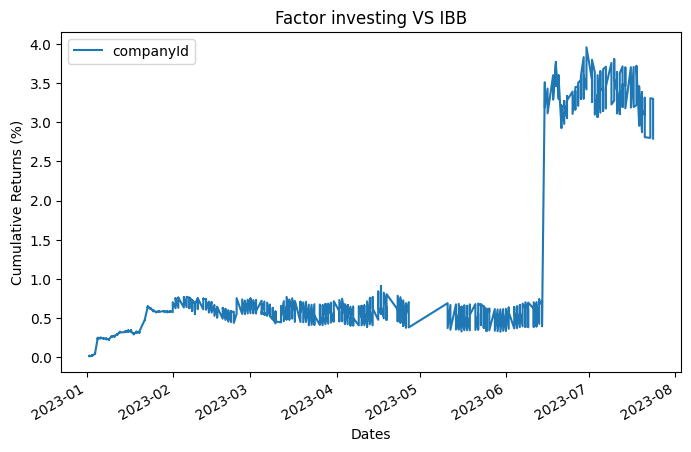

In [ ]:
import matplotlib.pyplot as plt
# Plot the DataFrame with legends
ax = fin_df.plot(linestyle='-', figsize=(8, 5))

# Set labels and title
ax.set_xlabel("Dates")
ax.set_ylabel("Cumulative Returns (%)")
ax.set_title("Factor investing VS IBB")

# Display the legend using the column names
ax.legend(df.columns)

# Show the plot
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd

# Define the date range
start_date = '2022-09-22'
end_date = '2023-09-22'

# Download historical data for S&P 500
IBB = yf.download('IBB', start=start_date, end=end_date)

# Extract the closing prices
IBB_close = IBB['Close']

# Calculate daily returns
IBB_returns = IBB_close.pct_change()

# Calculate total return
total_return = ((1 + IBB_returns).cumprod() - 1).dropna()
total_return

[*********************100%%**********************]  1 of 1 completed


Date
2022-09-23   -0.012079
2022-09-26   -0.028356
2022-09-27   -0.016363
2022-09-28    0.022274
2022-09-29    0.007453
                ...   
2023-09-15    0.084640
2023-09-18    0.072989
2023-09-19    0.076930
2023-09-20    0.067677
2023-09-21    0.054142
Name: Close, Length: 250, dtype: float64

In [ ]:
factor = ['Long-term Investments', 'Unearned Revenue Current, Total', 'Gain (Loss) On Sale Of Assets', 'EPS Normalized - Standard Deviation']
q = weights(factor)
q

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


,0
2022-09-23,-0.019843
2022-09-26,-0.036725
2022-09-27,-0.021103
2022-09-28,0.016698
2022-09-29,-0.006231
...,...
2023-09-18,0.797464
2023-09-19,0.988993
2023-09-20,0.937844
2023-09-21,0.909268


In [ ]:
z = q.copy()
df = pd.concat([z, total_return], axis=1)
df.dropna(inplace=True)
new_column_names = {
    0: factor[0],
    'Close': 'IBB',
}

df.rename(columns=new_column_names, inplace=True)
df

,Long-term Investments,IBB
2022-09-23,-0.019843,-0.012079
2022-09-26,-0.036725,-0.028356
2022-09-27,-0.021103,-0.016363
2022-09-28,0.016698,0.022274
2022-09-29,-0.006231,0.007453
...,...,...
2023-09-15,0.792941,0.084640
2023-09-18,0.797464,0.072989
2023-09-19,0.988993,0.076930
2023-09-20,0.937844,0.067677


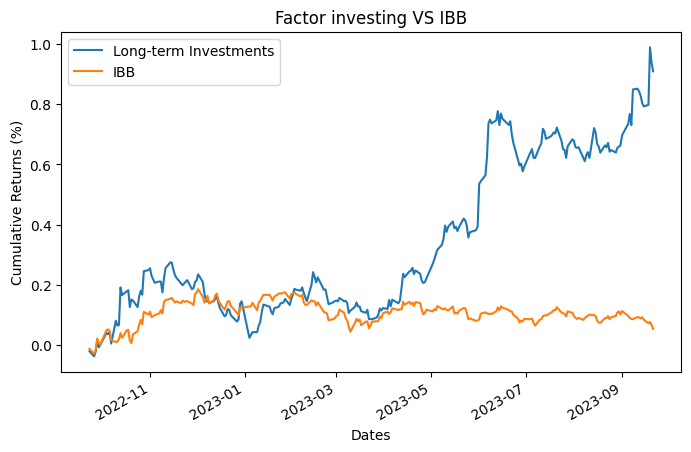

In [ ]:
# Plot the DataFrame with legends
ax = df.plot(linestyle='-', figsize=(8, 5))

# Set labels and title
ax.set_xlabel("Dates")
ax.set_ylabel("Cumulative Returns (%)")
ax.set_title("Factor investing VS IBB")

# Display the legend using the column names
ax.legend(df.columns)

# Show the plot
plt.show()